In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_PATH = "../donnees/ecommerce/"

In [2]:
# Chargement du parquet F_ACHATS créé dans l'analyse 1
F_ACHATS = pd.read_parquet("f_achats.parquet")

print("F_ACHATS chargé depuis f_achats.parquet")
print("Shape :", F_ACHATS.shape)
print("Colonnes :", list(F_ACHATS.columns))
display(F_ACHATS.head(3))

F_ACHATS chargé depuis f_achats.parquet
Shape : (112650, 13)
Colonnes : ['order_item_id', 'order_id', 'product_id', 'seller_id', 'customer_id', 'zip_code', 'purchase_timestamp', 'order_status', 'price', 'freight_value', 'line_revenue', 'line_total', 'limit']


,order_item_id,order_id,product_id,seller_id,customer_id,zip_code,purchase_timestamp,order_status,price,freight_value,line_revenue,line_total,limit
0,1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,28013,2017-09-13 08:59:02,delivered,58.9,13.29,58.9,72.19,144.775833
1,1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,15775,2017-04-26 10:53:06,delivered,239.9,19.93,239.9,259.83,168.201944
2,1,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,35661,2018-01-14 14:33:31,delivered,199.0,17.87,199.0,216.87,96.249722


In [3]:
# Recréation des dimensions de temps (locales, non sauvegardées dans le parquet)
F_ACHATS["year"]  = F_ACHATS["purchase_timestamp"].dt.year
F_ACHATS["month"] = F_ACHATS["purchase_timestamp"].dt.month
F_ACHATS["date"]  = F_ACHATS["purchase_timestamp"].dt.normalize()
F_ACHATS["week"]   = F_ACHATS["purchase_timestamp"].dt.isocalendar().week
F_ACHATS["weekday"] = F_ACHATS["purchase_timestamp"].dt.weekday
F_ACHATS["hour"]    = F_ACHATS["purchase_timestamp"].dt.hour

print("Colonnes temps ajoutées : year, month, date, week, weekday, hour")
display(
    F_ACHATS[["purchase_timestamp", "year", "month", "date", "week", "weekday", "hour"]]
    .head(3)
)

Colonnes temps ajoutées : year, month, date, week, weekday, hour


,purchase_timestamp,year,month,date,week,weekday,hour
0,2017-09-13 08:59:02,2017,9,2017-09-13,37,2,8
1,2017-04-26 10:53:06,2017,4,2017-04-26,17,2,10
2,2018-01-14 14:33:31,2018,1,2018-01-14,2,6,14


In [19]:
# Chargement des dimensions nécessaires pour l'analyse
products  = pd.read_parquet(DATA_PATH + "products.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")

print("Dimensions chargées :")
print("products :", products.shape)
print("customers:", customers.shape)

# Préparation de la dimension produit
prod_dim = products[["product_id", "category_name"]].copy()

# Préparation de la dimension client avec macro-région
cust_dim = customers[["customer_id", "state", "name_state"]].copy()

region_map = {
    "SP": "Sudeste", "RJ": "Sudeste", "MG": "Sudeste", "ES": "Sudeste",
    "RS": "Sul", "SC": "Sul", "PR": "Sul",
    "BA": "Nordeste", "PE": "Nordeste", "CE": "Nordeste", "RN": "Nordeste",
    "PB": "Nordeste", "AL": "Nordeste", "SE": "Nordeste", "PI": "Nordeste",
    "MA": "Nordeste",
    "DF": "Centro-Oeste", "GO": "Centro-Oeste", "MT": "Centro-Oeste", "MS": "Centro-Oeste",
    "AM": "Norte", "PA": "Norte", "RO": "Norte", "RR": "Norte",
    "AP": "Norte", "TO": "Norte", "AC": "Norte"
}

cust_dim["macro_region"] = cust_dim["state"].map(region_map)

products  = pd.read_parquet(DATA_PATH + "products.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
sellers   = pd.read_parquet(DATA_PATH + "sellers.parquet")

print("Dimensions produit et client préparées")

Dimensions chargées :
products : (32951, 9)
customers: (99441, 6)
Dimensions produit et client préparées


In [5]:
# Analyse 3 : Rôle des vendeurs & fragmentation des commandes
# Dans cette troisième analyse sur l’étoile 2, on s’intéresse au rôle des vendeurs
# dans la performance des achats : concentration du line_total par seller_id,
# structure des commandes mono-vendeur vs multi-vendeurs, et impact sur les coûts
# logistiques (freight_value) et les délais (limit). L’idée est de partir d’une vue
# très agrégée par vendeur, puis de descendre dans les hiérarchies temps / vendeur /
# géographie pour voir comment la fragmentation des commandes entre plusieurs sellers
# affecte le panier total, la part logistique et le risque de statut défavorable
# (shipped en retard, canceled, etc.) au niveau ligne de commande.

In [6]:
# Hypothèse 3
# On suppose qu’une petite poignée de vendeurs “structurants” concentre l’essentiel
# des achats avec des commandes plutôt mono-vendeur, ce qui rend la logistique plus
# efficace (part logistique plus faible, délais mieux tenus). À l’inverse, on s’attend
# à ce que les commandes éclatées entre plusieurs vendeurs, souvent sur des produits
# volumineux ou peu chers, génèrent une part de freight_value plus élevée, des délais
# limit plus tendus et un risque plus important de statuts défavorables. Autrement dit,
# ce n’est pas seulement le couple produit × région qui crée de la complexité, mais
# aussi la façon dont les commandes sont réparties entre les vendeurs au sein d’un
# même panier, en particulier pendant les périodes de forte saisonnalité identifiées
# dans les analyses précédentes.

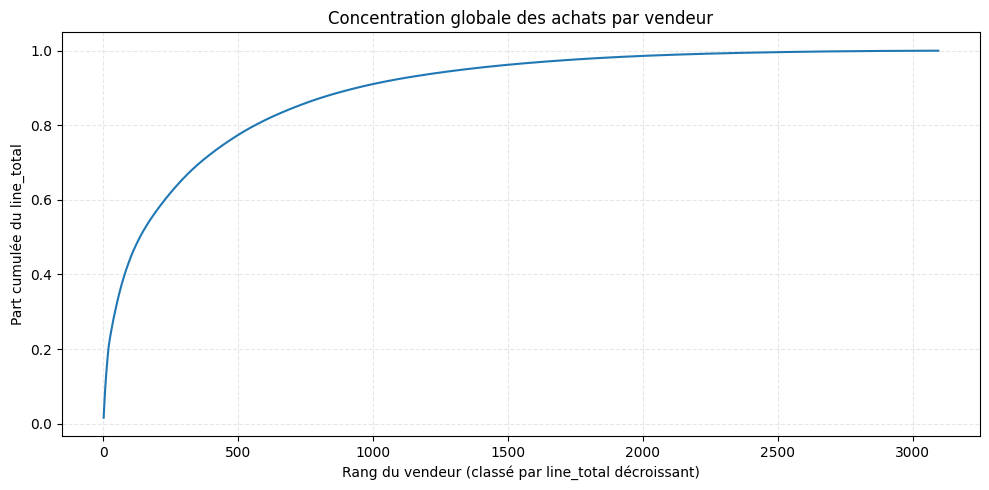

In [8]:
# 1 Concentration globale des achats par vendeur (Top sellers vs “long tail”)

# préparation
seller_sales = (
    F_ACHATS.groupby("seller_id")["line_total"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
seller_sales["rank"] = np.arange(1, len(seller_sales) + 1)
seller_sales["cum_share"] = seller_sales["line_total"].cumsum() / seller_sales["line_total"].sum()

# affichage
plt.figure(figsize=(10, 5))
sns.lineplot(data=seller_sales, x="rank", y="cum_share")
plt.xlabel("Rang du vendeur (classé par line_total décroissant)")
plt.ylabel("Part cumulée du line_total")
plt.title("Concentration globale des achats par vendeur")
plt.grid(True, axis="both", linestyle="--", alpha=0.3)
plt.tight_layout()


In [ ]:
# Ce premier graphique montre une forte concentration des achats : la courbe est très pentue sur les premiers rangs, puis s’aplatit rapidement.
# Autrement dit, un noyau restreint de vendeurs dits « structurants » capte la majorité du line_total, tandis qu’une longue traîne de petits vendeurs se partage le reste.
# Ce résultat va dans le sens de notre hypothèse 3 : la plateforme repose sur quelques acteurs majeurs, autour desquels s’organise l’essentiel des flux logistiques.
# En lien avec les analyses précédentes sur la saisonnalité et les catégories produits, on peut supposer que ces vendeurs structurants sont particulièrement actifs sur les périodes et segments déjà identifiés comme porteurs.
# La longue traîne de vendeurs, très nombreuse mais peu contributrice en valeur individuelle, complique néanmoins la gestion opérationnelle (multiplication des points d’expédition).
# Cette structure de marché laisse penser que les commandes mono-vendeur sont probablement concentrées chez ces gros acteurs, alors que les commandes éclatées entre plusieurs vendeurs concernent davantage la partie « long tail ».
# Les graphiques suivants chercheront à confirmer cette intuition en croisant le rôle des vendeurs avec la fragmentation des commandes, les coûts de freight_value et les délais limit.


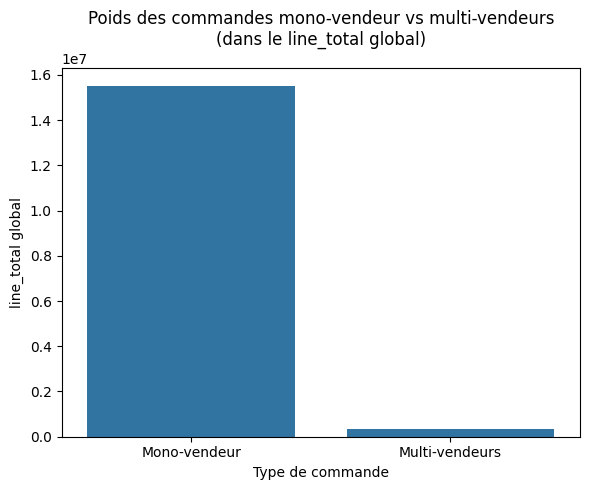

In [9]:
# 2 Poids des commandes mono-vendeur vs multi-vendeurs dans le line_total global
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_totals = (
    F_ACHATS.groupby("order_id")["line_total"]
    .sum()
    .reset_index(name="order_total")
)

orders_type = orders_sellers.merge(order_totals, on="order_id", how="left")

type_agg = (
    orders_type.groupby("order_type")["order_total"]
    .sum()
    .reset_index()
    .sort_values("order_total", ascending=False)
)

# affichage
plt.figure(figsize=(6, 5))
sns.barplot(data=type_agg, x="order_type", y="order_total")
plt.xlabel("Type de commande")
plt.ylabel("line_total global")
plt.title("Poids des commandes mono-vendeur vs multi-vendeurs\n(dans le line_total global)")
plt.tight_layout()


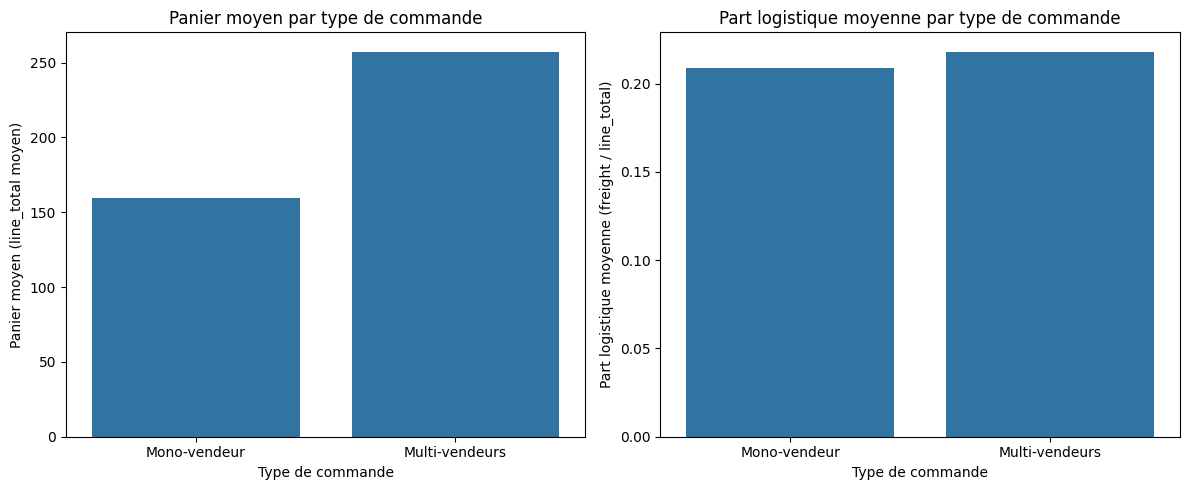

In [10]:
# 3 Panier moyen et part logistique selon le type de commande (mono-vendeur vs multi-vendeurs)
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_metrics = (
    F_ACHATS.groupby("order_id")[["line_total", "freight_value"]]
    .sum()
    .reset_index()
)
order_metrics["freight_share"] = order_metrics["freight_value"] / order_metrics["line_total"]

orders_type = orders_sellers.merge(order_metrics, on="order_id", how="left")

type_stats = (
    orders_type.groupby("order_type")
    .agg(
        avg_basket=("line_total", "mean"),
        avg_freight_share=("freight_share", "mean"),
    )
    .reset_index()
)

# affichage
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=type_stats, x="order_type", y="avg_basket", ax=axes[0])
axes[0].set_xlabel("Type de commande")
axes[0].set_ylabel("Panier moyen (line_total moyen)")
axes[0].set_title("Panier moyen par type de commande")

sns.barplot(data=type_stats, x="order_type", y="avg_freight_share", ax=axes[1])
axes[1].set_xlabel("Type de commande")
axes[1].set_ylabel("Part logistique moyenne (freight / line_total)")
axes[1].set_title("Part logistique moyenne par type de commande")

plt.tight_layout()


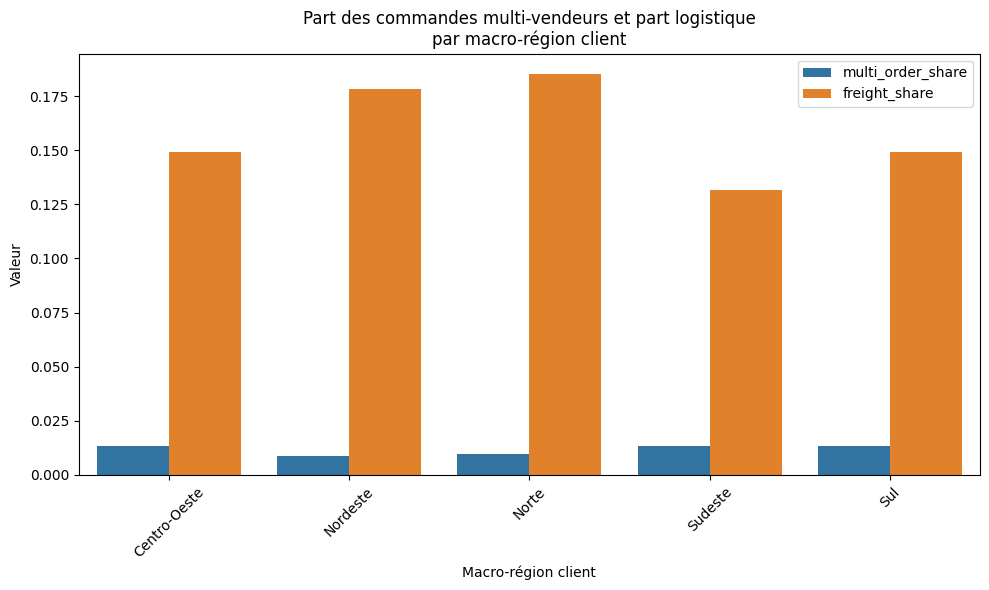

In [11]:
# 4 Part des commandes multi-vendeurs et part logistique par macro-région client
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_metrics = (
    F_ACHATS.groupby("order_id")[["line_total", "freight_value"]]
    .sum()
    .reset_index()
)

orders_cust = (
    F_ACHATS[["order_id", "customer_id"]]
    .drop_duplicates()
    .merge(
        cust_dim[["customer_id", "macro_region"]],
        on="customer_id",
        how="left",
    )
)

orders_full = (
    orders_cust
    .merge(orders_sellers[["order_id", "order_type"]], on="order_id", how="left")
    .merge(order_metrics, on="order_id", how="left")
)

region_stats = (
    orders_full.dropna(subset=["macro_region"])
    .groupby("macro_region")
    .agg(
        total_orders=("order_id", "nunique"),
        multi_orders=("order_type", lambda x: (x == "Multi-vendeurs").sum()),
        freight_sum=("freight_value", "sum"),
        line_total_sum=("line_total", "sum"),
    )
    .reset_index()
)
region_stats["multi_order_share"] = region_stats["multi_orders"] / region_stats["total_orders"]
region_stats["freight_share"] = region_stats["freight_sum"] / region_stats["line_total_sum"]

plot_df = region_stats.melt(
    id_vars="macro_region",
    value_vars=["multi_order_share", "freight_share"],
    var_name="metric",
    value_name="value",
)

# affichage
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="macro_region", y="value", hue="metric")
plt.xlabel("Macro-région client")
plt.ylabel("Valeur")
plt.title("Part des commandes multi-vendeurs et part logistique\npar macro-région client")
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()


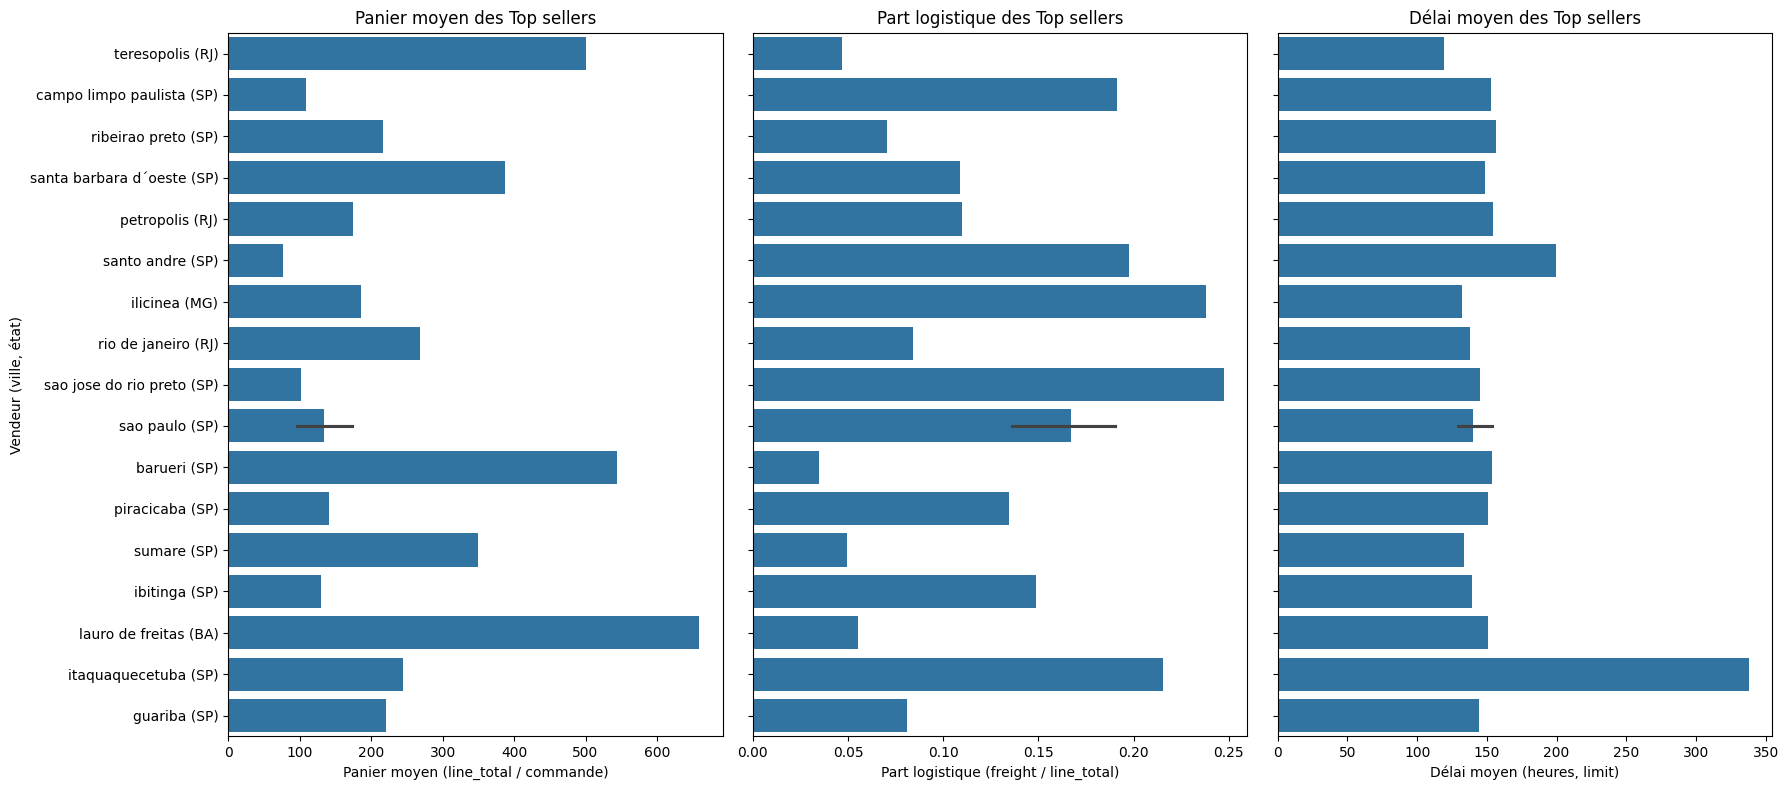

In [21]:
# 5 Performance logistique des Top sellers : panier moyen, part logistique et délai moyen par vendeur
# préparation
seller_stats = (
    F_ACHATS.groupby("seller_id")
    .agg(
        total_line=("line_total", "sum"),
        total_freight=("freight_value", "sum"),
        avg_limit=("limit", "mean"),
        n_orders=("order_id", "nunique"),
    )
    .reset_index()
)
seller_stats["avg_basket"] = seller_stats["total_line"] / seller_stats["n_orders"]
seller_stats["freight_share"] = seller_stats["total_freight"] / seller_stats["total_line"]

top_sellers = (
    seller_stats.sort_values("total_line", ascending=False)
    .head(20)
    .merge(sellers[["seller_id", "city", "state"]], on="seller_id", how="left")
)

top_sellers["seller_label"] = (
    top_sellers["city"].fillna("NA") + " (" + top_sellers["state"].fillna("") + ")"
)

top_sellers = top_sellers.sort_values("total_line", ascending=True)
order_labels = top_sellers["seller_label"].tolist()

# affichage
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

sns.barplot(
    data=top_sellers,
    x="avg_basket",
    y="seller_label",
    ax=axes[0],
    orient="h",
    order=order_labels,
)
axes[0].set_xlabel("Panier moyen (line_total / commande)")
axes[0].set_ylabel("Vendeur (ville, état)")
axes[0].set_title("Panier moyen des Top sellers")

sns.barplot(
    data=top_sellers,
    x="freight_share",
    y="seller_label",
    ax=axes[1],
    orient="h",
    order=order_labels,
)
axes[1].set_xlabel("Part logistique (freight / line_total)")
axes[1].set_ylabel("")
axes[1].set_title("Part logistique des Top sellers")

sns.barplot(
    data=top_sellers,
    x="avg_limit",
    y="seller_label",
    ax=axes[2],
    orient="h",
    order=order_labels,
)
axes[2].set_xlabel("Délai moyen (heures, limit)")
axes[2].set_ylabel("")
axes[2].set_title("Délai moyen des Top sellers")

plt.tight_layout()


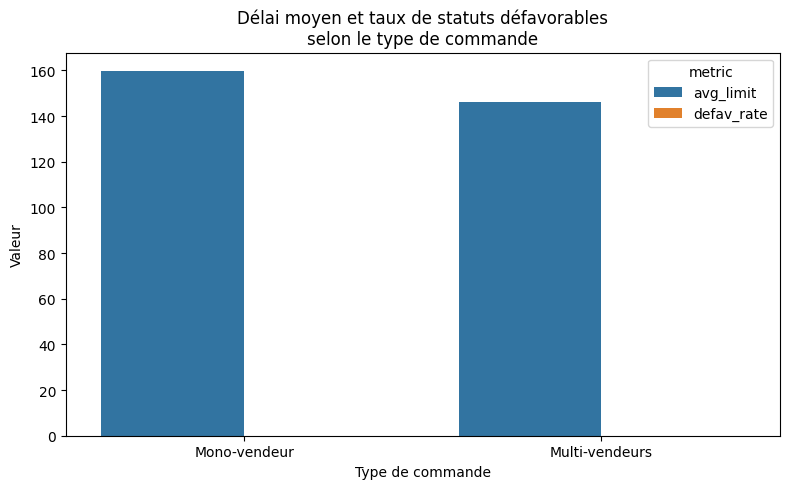

In [13]:
# 6 Impact de la fragmentation sur les délais et statuts : délai limit moyen et taux de statuts défavorables selon le type de commande
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

lines = F_ACHATS.merge(
    orders_sellers[["order_id", "order_type"]],
    on="order_id",
    how="left",
)

bad_statuses = ["canceled", "unavailable"]
lines["defav"] = lines["order_status"].str.lower().isin(bad_statuses).astype(int)

impact_stats = (
    lines.groupby("order_type")
    .agg(
        avg_limit=("limit", "mean"),
        defav_rate=("defav", "mean"),
    )
    .reset_index()
)

plot_df = impact_stats.melt(
    id_vars="order_type",
    value_vars=["avg_limit", "defav_rate"],
    var_name="metric",
    value_name="value",
)

# affichage
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x="order_type", y="value", hue="metric")
plt.xlabel("Type de commande")
plt.ylabel("Valeur")
plt.title("Délai moyen et taux de statuts défavorables\nselon le type de commande")
plt.tight_layout()


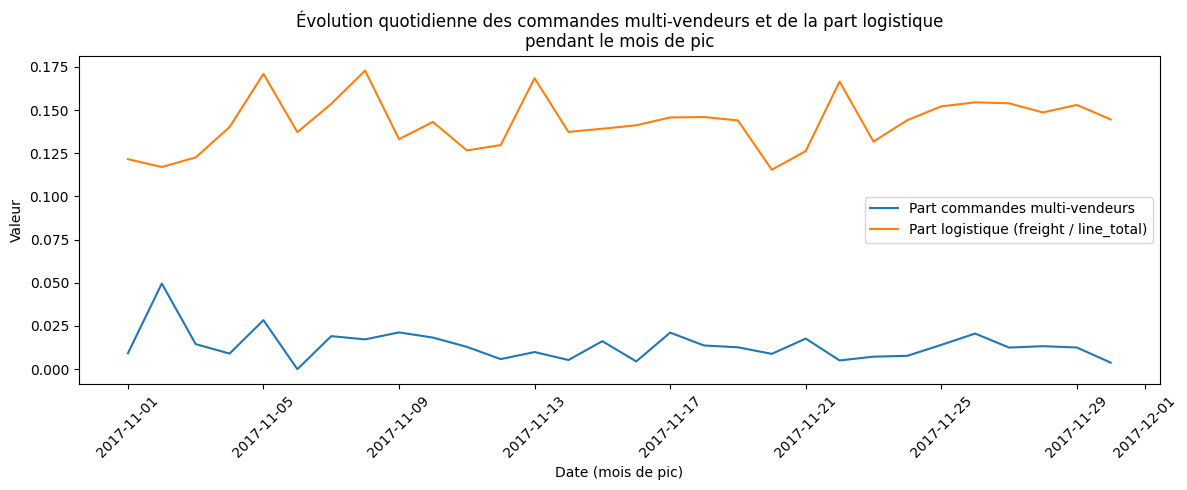

In [14]:
# 7 Mois de pic : évolution quotidienne de la part de commandes multi-vendeurs et de la part logistique
# préparation
monthly_sales = (
    F_ACHATS.groupby(["year", "month"])["line_total"]
    .sum()
    .reset_index()
)
peak_row = monthly_sales.loc[monthly_sales["line_total"].idxmax()]
peak_year = peak_row["year"]
peak_month = peak_row["month"]

F_peak = F_ACHATS[(F_ACHATS["year"] == peak_year) & (F_ACHATS["month"] == peak_month)].copy()

orders_sellers_peak = (
    F_peak.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers_peak["order_type"] = np.where(
    orders_sellers_peak["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_daily = (
    F_peak.groupby("order_id")
    .agg(
        date=("date", "first"),
        line_total=("line_total", "sum"),
        freight_value=("freight_value", "sum"),
    )
    .reset_index()
)
order_daily = order_daily.merge(
    orders_sellers_peak[["order_id", "order_type"]],
    on="order_id",
    how="left",
)

daily_stats = (
    order_daily.groupby("date")
    .agg(
        total_orders=("order_id", "nunique"),
        multi_orders=("order_type", lambda x: (x == "Multi-vendeurs").sum()),
        freight_sum=("freight_value", "sum"),
        line_sum=("line_total", "sum"),
    )
    .reset_index()
)
daily_stats["multi_order_share"] = daily_stats["multi_orders"] / daily_stats["total_orders"]
daily_stats["freight_share"] = daily_stats["freight_sum"] / daily_stats["line_sum"]

# affichage
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_stats, x="date", y="multi_order_share", label="Part commandes multi-vendeurs")
sns.lineplot(data=daily_stats, x="date", y="freight_share", label="Part logistique (freight / line_total)")
plt.xlabel("Date (mois de pic)")
plt.ylabel("Valeur")
plt.title("Évolution quotidienne des commandes multi-vendeurs et de la part logistique\npendant le mois de pic")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()


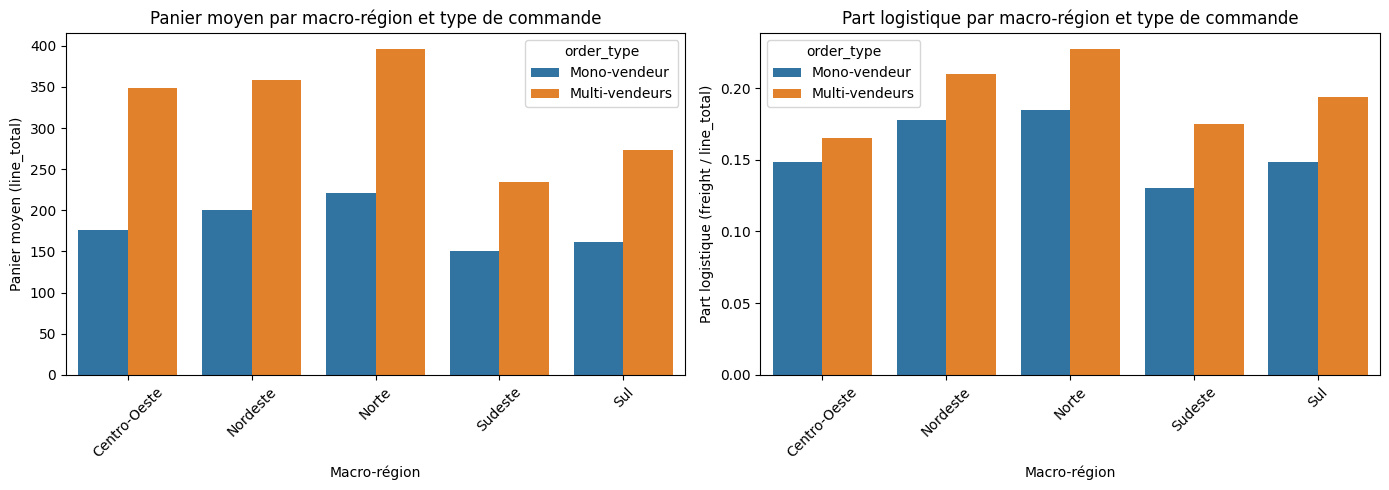

In [15]:
# 8 Segments géographiques critiques : panier moyen et part logistique selon macro-région × type de commande
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_metrics = (
    F_ACHATS.groupby("order_id")[["line_total", "freight_value"]]
    .sum()
    .reset_index()
)

orders_cust = (
    F_ACHATS[["order_id", "customer_id"]]
    .drop_duplicates()
    .merge(
        cust_dim[["customer_id", "macro_region"]],
        on="customer_id",
        how="left",
    )
)

orders_full = (
    orders_cust
    .merge(orders_sellers[["order_id", "order_type"]], on="order_id", how="left")
    .merge(order_metrics, on="order_id", how="left")
)

seg_stats = (
    orders_full.dropna(subset=["macro_region", "order_type"])
    .groupby(["macro_region", "order_type"])
    .agg(
        total_line=("line_total", "sum"),
        total_freight=("freight_value", "sum"),
        avg_order_total=("line_total", "mean"),
    )
    .reset_index()
)
seg_stats["freight_share"] = seg_stats["total_freight"] / seg_stats["total_line"]

# affichage
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.barplot(
    data=seg_stats,
    x="macro_region",
    y="avg_order_total",
    hue="order_type",
    ax=axes[0],
)
axes[0].set_xlabel("Macro-région")
axes[0].set_ylabel("Panier moyen (line_total)")
axes[0].set_title("Panier moyen par macro-région et type de commande")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(
    data=seg_stats,
    x="macro_region",
    y="freight_share",
    hue="order_type",
    ax=axes[1],
)
axes[1].set_xlabel("Macro-région")
axes[1].set_ylabel("Part logistique (freight / line_total)")
axes[1].set_title("Part logistique par macro-région et type de commande")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()


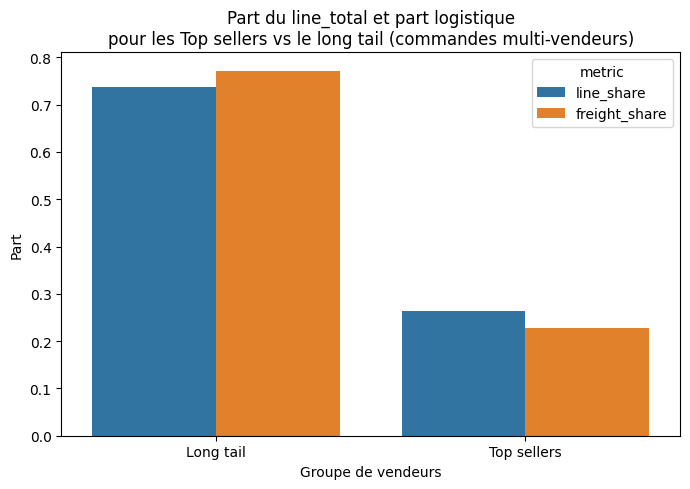

In [16]:
# 9 Rôle des “gros vendeurs” dans les commandes multi-vendeurs : part du line_total et part logistique Top sellers vs “long tail”
# préparation
seller_totals = (
    F_ACHATS.groupby("seller_id")["line_total"]
    .sum()
    .sort_values(ascending=False)
)
top_seller_ids = set(seller_totals.head(50).index)

orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
multi_orders = orders_sellers.loc[orders_sellers["seller_count"] > 1, "order_id"]

F_multi = F_ACHATS[F_ACHATS["order_id"].isin(multi_orders)].copy()
F_multi["seller_group"] = np.where(
    F_multi["seller_id"].isin(top_seller_ids),
    "Top sellers",
    "Long tail",
)

group_stats = (
    F_multi.groupby("seller_group")
    .agg(
        line_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum"),
    )
    .reset_index()
)
group_stats["line_share"] = group_stats["line_sum"] / group_stats["line_sum"].sum()
group_stats["freight_share"] = group_stats["freight_sum"] / group_stats["freight_sum"].sum()

plot_df = group_stats.melt(
    id_vars="seller_group",
    value_vars=["line_share", "freight_share"],
    var_name="metric",
    value_name="value",
)

# affichage
plt.figure(figsize=(7, 5))
sns.barplot(data=plot_df, x="seller_group", y="value", hue="metric")
plt.xlabel("Groupe de vendeurs")
plt.ylabel("Part")
plt.title("Part du line_total et part logistique\npour les Top sellers vs le long tail (commandes multi-vendeurs)")
plt.tight_layout()
